# Experimentación con Modelos Simples - Grupo 2

**Objetivo**: Experimentar con modelos simples de series de tiempo para agregación Día/Producto

**Modelos Disponibles (Post-Limpieza)**:
1. **Moving Average**: Promedio móvil simple
2. **Linear Trend**: Tendencia lineal  
3. **Seasonal Naive**: Predicción estacional ingenua

**Grupo**: 2 - Agregación Día/Producto

**Nota**: Este notebook ha sido actualizado para funcionar solo con los modelos simples disponibles después de la limpieza del proyecto.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Imports del proyecto (solo los que existen después de la limpieza)
import sys
sys.path.append(str(Path('..').resolve() / 'src'))

from preprocess.preprocessing import DataPreprocessor
from preprocess.aggregation import aggregate_daily_product_data
from preprocess.cleaning import clean_data
from models.G2_LACC_simple_models import SimpleMovingAverage, LinearTrend, SeasonalNaive

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
pd.set_option('display.max_columns', None)

## 1. Carga y Preprocessing de Datos

In [2]:
# Cargar y procesar datos simplificado
data_file = '../data/raw/data_sample.parquet'

try:
    # Cargar datos raw
    df = pd.read_parquet(data_file)
    print(f"Datos cargados: {df.shape}")
    
    # Limpieza básica
    df_clean = clean_data(df)
    print(f"Datos limpios: {df_clean.shape}")
    
    # Agregación día/producto para Grupo 2
    df_processed = aggregate_daily_product_data(
        df_clean,
        date_column='parsed_date',
        product_columns=['product_sku', 'product_name'],
        value_columns=['product_revenue_usd', 'product_quantity']
    )
    
    print(f"Datos procesados exitosamente:")
    print(f"Shape: {df_processed.shape}")
    print(f"Productos únicos: {df_processed['product_id'].nunique()}")
    print(f"Rango de fechas: {df_processed['date'].min()} - {df_processed['date'].max()}")
    
except Exception as e:
    # Crear datos sintéticos para el ejemplo
    print(f"Error procesando datos reales: {e}")
    print("Creando datos sintéticos para demostración...")
    
    np.random.seed(42)
    dates = pd.date_range('2023-01-01', periods=90, freq='D')
    products = ['PROD_A', 'PROD_B', 'PROD_C']
    
    data = []
    for product in products:
        base_value = np.random.uniform(100, 500)
        trend = np.random.uniform(-0.5, 0.5)
        
        for i, date in enumerate(dates):
            seasonal = 20 * np.sin(2 * np.pi * i / 7)
            trend_component = trend * i
            noise = np.random.normal(0, 10)
            
            revenue = max(0, base_value + seasonal + trend_component + noise)
            
            data.append({
                'date': date,
                'product_id': product,
                'revenue_sum': revenue,
                'visits_sum': max(1, int(revenue / 10)),
                'transactions_sum': max(1, int(revenue / 50))
            })
    
    df_processed = pd.DataFrame(data)
    print(f"Datos sintéticos creados: {df_processed.shape}")

Datos cargados: (74457, 77)
Limpiando datos...
Datos antes: (74457, 77)
Datos después: (74457, 78)
Datos limpios: (74457, 78)
Error procesando datos reales: aggregate_daily_product_data() got an unexpected keyword argument 'product_columns'
Creando datos sintéticos para demostración...
Datos sintéticos creados: (270, 5)


In [3]:
# Explorar datos procesados
df_processed.head()

,date,product_id,revenue_sum,visits_sum,transactions_sum
0,2023-01-01,PROD_A,256.292933,25,5
1,2023-01-02,PROD_A,281.133690,28,5
2,2023-01-03,PROD_A,267.874501,26,5
3,2023-01-04,PROD_A,257.504496,25,5
4,2023-01-05,PROD_A,258.733358,25,5


In [4]:
# Estadísticas por producto
product_stats = df_processed.groupby('product_id').agg({
    'date': ['min', 'max', 'count'],
    'revenue_sum': ['mean', 'std', 'min', 'max']
})

print("Estadísticas por producto:")
print(product_stats)

Estadísticas por producto:
                 date                  revenue_sum                         \
                  min        max count        mean        std         min   
product_id                                                                  
PROD_A     2023-01-01 2023-03-31    90  269.137078  21.487596  218.476883   
PROD_B     2023-01-01 2023-03-31    90  441.176987  20.313244  402.240319   
PROD_C     2023-01-01 2023-03-31    90  191.241724  22.416989  136.115886   

                        
                   max  
product_id              
PROD_A      313.099830  
PROD_B      493.315372  
PROD_C      236.090335  


## 2. Visualización de Series de Tiempo

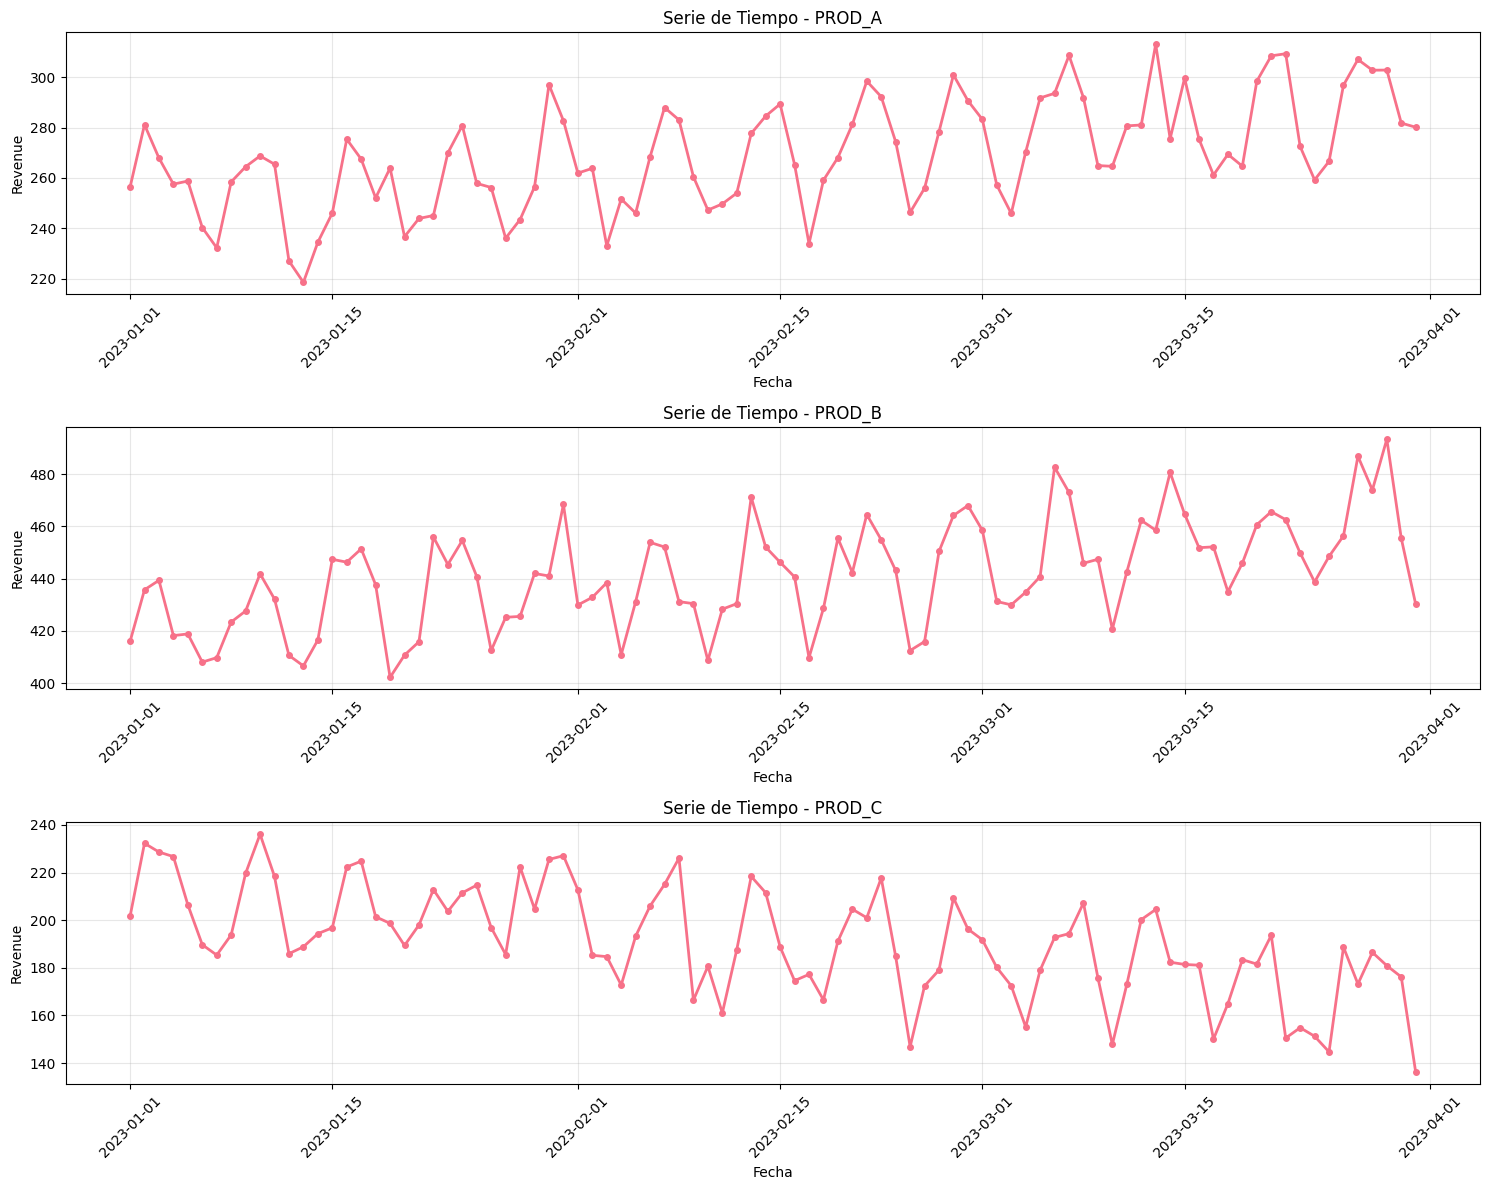

In [5]:
# Visualizar series de tiempo por producto
fig, axes = plt.subplots(len(df_processed['product_id'].unique()), 1, 
                        figsize=(15, 4 * len(df_processed['product_id'].unique())))

if len(df_processed['product_id'].unique()) == 1:
    axes = [axes]

for i, product in enumerate(df_processed['product_id'].unique()):
    product_data = df_processed[df_processed['product_id'] == product].copy()
    product_data = product_data.sort_values('date')
    
    axes[i].plot(product_data['date'], product_data['revenue_sum'], 
                marker='o', linewidth=2, markersize=4)
    axes[i].set_title(f'Serie de Tiempo - {product}')
    axes[i].set_xlabel('Fecha')
    axes[i].set_ylabel('Revenue')
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

## 3. Preparación de Datos para Modelado

In [6]:
# Preparar datos para entrenamiento y validación
def prepare_train_test_data(df, target_col='revenue_sum', test_size=0.2):
    """
    Prepara datos de entrenamiento y test por producto.
    """
    train_data = {}
    test_data = {}
    
    for product in df['product_id'].unique():
        product_data = df[df['product_id'] == product].copy()
        product_data = product_data.sort_values('date')
        
        # Dividir por tiempo (últimos datos para test)
        n_test = int(len(product_data) * test_size)
        
        train_subset = product_data.iloc[:-n_test]
        test_subset = product_data.iloc[-n_test:]
        
        # Para modelos estadísticos (solo target)
        train_data[product] = train_subset[target_col]
        test_data[product] = test_subset[target_col]
    
    return train_data, test_data

# Preparar datos
train_data, test_data = prepare_train_test_data(df_processed)

print("Datos preparados:")
for product in train_data.keys():
    print(f"{product}: Train={len(train_data[product])}, Test={len(test_data[product])}")

Datos preparados:
PROD_A: Train=72, Test=18
PROD_B: Train=72, Test=18
PROD_C: Train=72, Test=18


## 4. Experimentación con Modelos Estadísticos

In [7]:
# Función simplificada para evaluar modelo en un producto
def evaluate_simple_model_on_product(model_class, product_id, train_series, test_series, **model_kwargs):
    """
    Evalúa un modelo simple en un producto específico.
    """
    try:
        # Crear y entrenar modelo
        model = model_class(**model_kwargs)
        model.fit(train_series)
        
        # Predecir
        predictions = model.predict(len(test_series))
        
        # Calcular métricas básicas
        from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
        
        mae = mean_absolute_error(test_series.values, predictions)
        rmse = np.sqrt(mean_squared_error(test_series.values, predictions))
        
        # MAPE
        mape = np.mean(np.abs((test_series.values - predictions) / test_series.values)) * 100
        
        # R2
        try:
            r2 = r2_score(test_series.values, predictions)
        except:
            r2 = -1
        
        metrics = {
            'mae': mae,
            'rmse': rmse,
            'mape': mape,
            'r2': r2
        }
        
        return {
            'model': model,
            'predictions': predictions,
            'metrics': metrics,
            'success': True
        }
        
    except Exception as e:
        print(f"Error en {model_class.__name__} para {product_id}: {e}")
        return {
            'model': None,
            'predictions': np.full(len(test_series), train_series.mean()),  # Fallback
            'metrics': {'mae': float('inf'), 'rmse': float('inf'), 'mape': float('inf'), 'r2': -1},
            'success': False
        }

# Experimentar con nuestros modelos simples disponibles
simple_models = {
    'Moving_Average': (SimpleMovingAverage, {'window': 7}),
    'Linear_Trend': (LinearTrend, {}),
    'Seasonal_Naive': (SeasonalNaive, {'season_length': 7})
}

simple_results = {}

for model_name, (model_class, model_kwargs) in simple_models.items():
    print(f"\nExperimentando con {model_name}...")
    
    model_results = {}
    
    for product in train_data.keys():
        print(f"  Evaluando {product}...")
        
        result = evaluate_simple_model_on_product(
            model_class=model_class,
            product_id=product,
            train_series=train_data[product],
            test_series=test_data[product],
            **model_kwargs
        )
        
        model_results[product] = result
    
    simple_results[model_name] = model_results

print("\nExperimentación con modelos simples completada.")


Experimentando con Moving_Average...
  Evaluando PROD_A...
  Evaluando PROD_B...
  Evaluando PROD_C...

Experimentando con Linear_Trend...
  Evaluando PROD_A...
  Evaluando PROD_B...
  Evaluando PROD_C...

Experimentando con Seasonal_Naive...
  Evaluando PROD_A...
  Evaluando PROD_B...
  Evaluando PROD_C...

Experimentación con modelos simples completada.


## 5. Comparación de Resultados

In [8]:
# Compilar resultados para comparación (actualizado para modelos simples)
comparison_results = []

for model_name, model_results in simple_results.items():
    for product, result in model_results.items():
        if result['success']:
            metrics = result['metrics']
            comparison_results.append({
                'Model': model_name,
                'Product': product,
                'MAE': metrics.get('mae', float('inf')),
                'RMSE': metrics.get('rmse', float('inf')),
                'MAPE': metrics.get('mape', float('inf')),
                'R2': metrics.get('r2', -float('inf')),
                'Success': True
            })
        else:
            comparison_results.append({
                'Model': model_name,
                'Product': product,
                'MAE': float('inf'),
                'RMSE': float('inf'),
                'MAPE': float('inf'),
                'R2': -float('inf'),
                'Success': False
            })

# Crear DataFrame de comparación
df_comparison = pd.DataFrame(comparison_results)
print("Comparación de Modelos Simples:")
print(df_comparison)

Comparación de Modelos Simples:
            Model Product        MAE       RMSE       MAPE        R2  Success
0  Moving_Average  PROD_A  16.219708  17.378580   5.732178 -0.005682     True
1  Moving_Average  PROD_B  14.199517  18.711434   3.035661 -0.252868     True
2  Moving_Average  PROD_C  17.215263  23.430952  11.226942 -0.886750     True
3    Linear_Trend  PROD_A  35.616322  39.350652  12.887073 -4.156276     True
4    Linear_Trend  PROD_B  14.692200  17.804291   3.234232 -0.134333     True
5    Linear_Trend  PROD_C  34.801189  38.776934  21.766538 -4.167510     True
6  Seasonal_Naive  PROD_A  11.830362  13.836569   4.181648  0.362487     True
7  Seasonal_Naive  PROD_B  13.271371  17.783177   2.860361 -0.131644     True
8  Seasonal_Naive  PROD_C  16.244294  21.335017   9.838528 -0.564301     True


In [9]:
# Resumen por modelo
model_summary = df_comparison.groupby('Model').agg({
    'MAE': ['mean', 'std'],
    'RMSE': ['mean', 'std'],
    'MAPE': ['mean', 'std'],
    'R2': ['mean', 'std'],
    'Success': 'sum'
})

print("\nResumen por Modelo:")
print(model_summary)


Resumen por Modelo:
                      MAE                  RMSE                  MAPE  \
                     mean        std       mean        std       mean   
Model                                                                   
Linear_Trend    28.369904  11.852249  31.977292  12.277531  12.629281   
Moving_Average  15.878163   1.536610  19.840322   3.180188   6.664927   
Seasonal_Naive  13.782009   2.250836  17.651588   3.750955   5.626846   

                                R2           Success  
                     std      mean       std     sum  
Model                                                 
Linear_Trend    9.268842 -2.819373  2.325320       3  
Moving_Average  4.174540 -0.381767  0.454457       3  
Seasonal_Naive  3.706771 -0.111153  0.463734       3  


## 6. Visualización de Predicciones

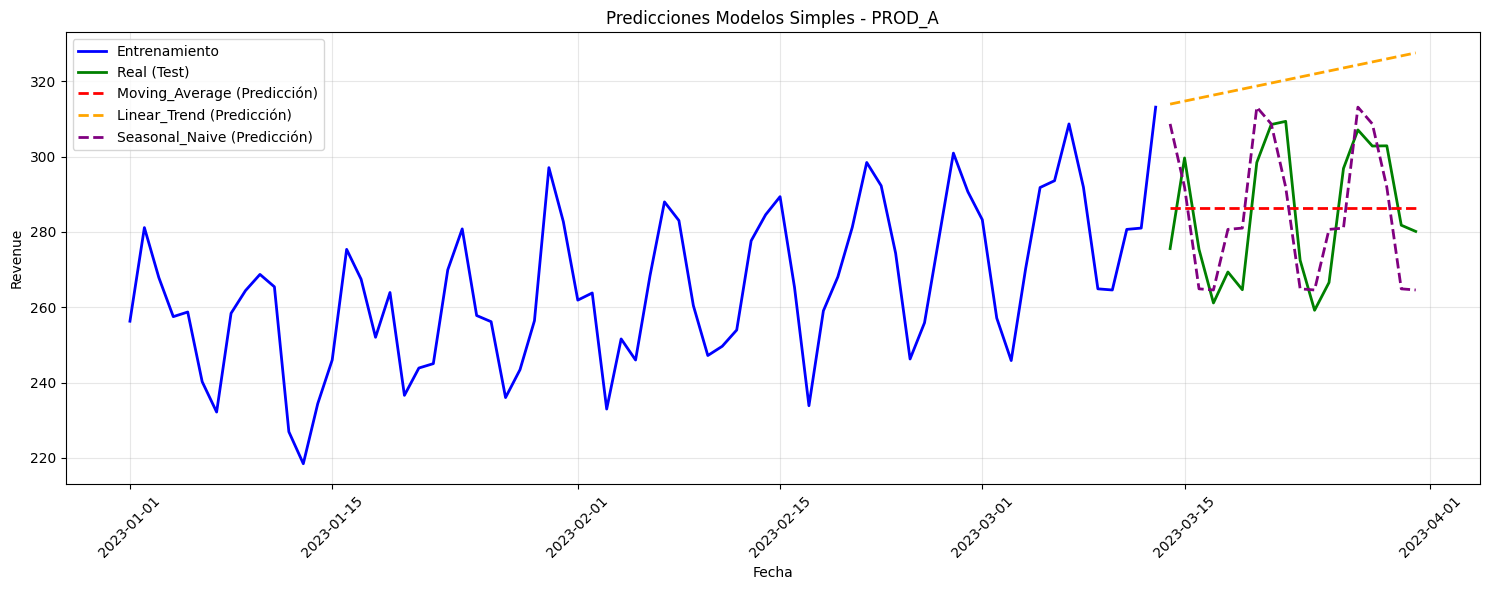

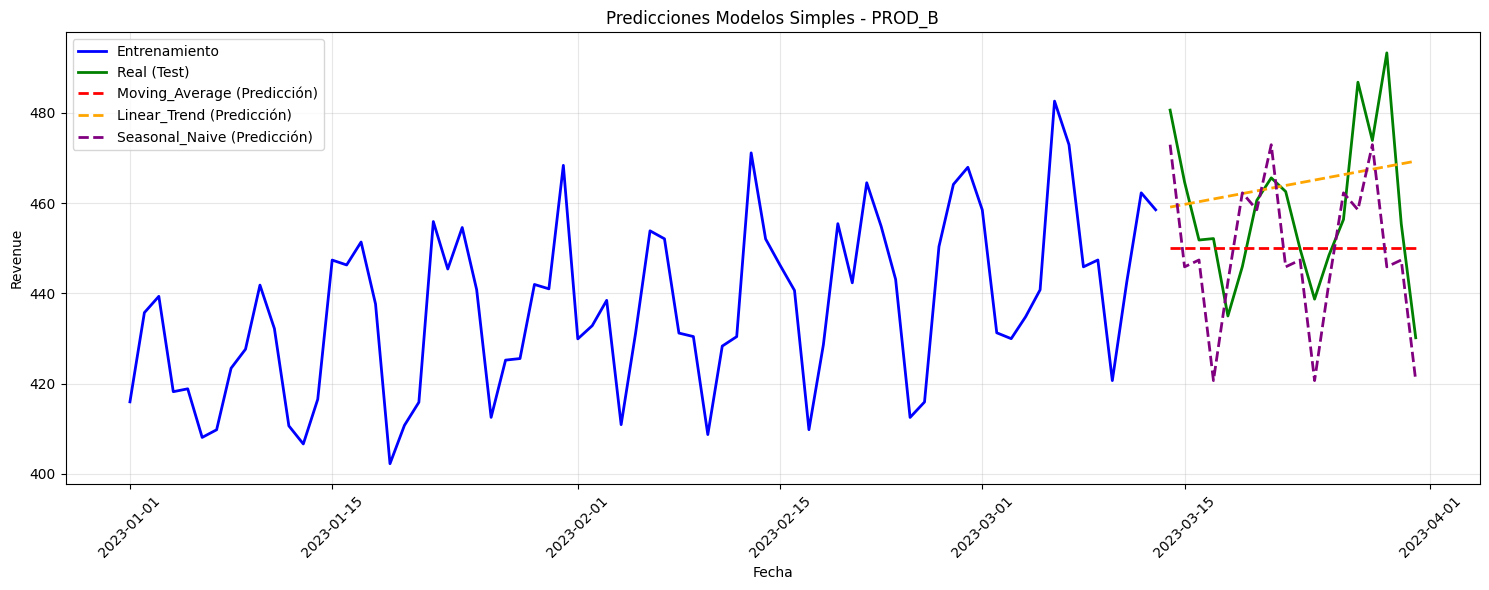

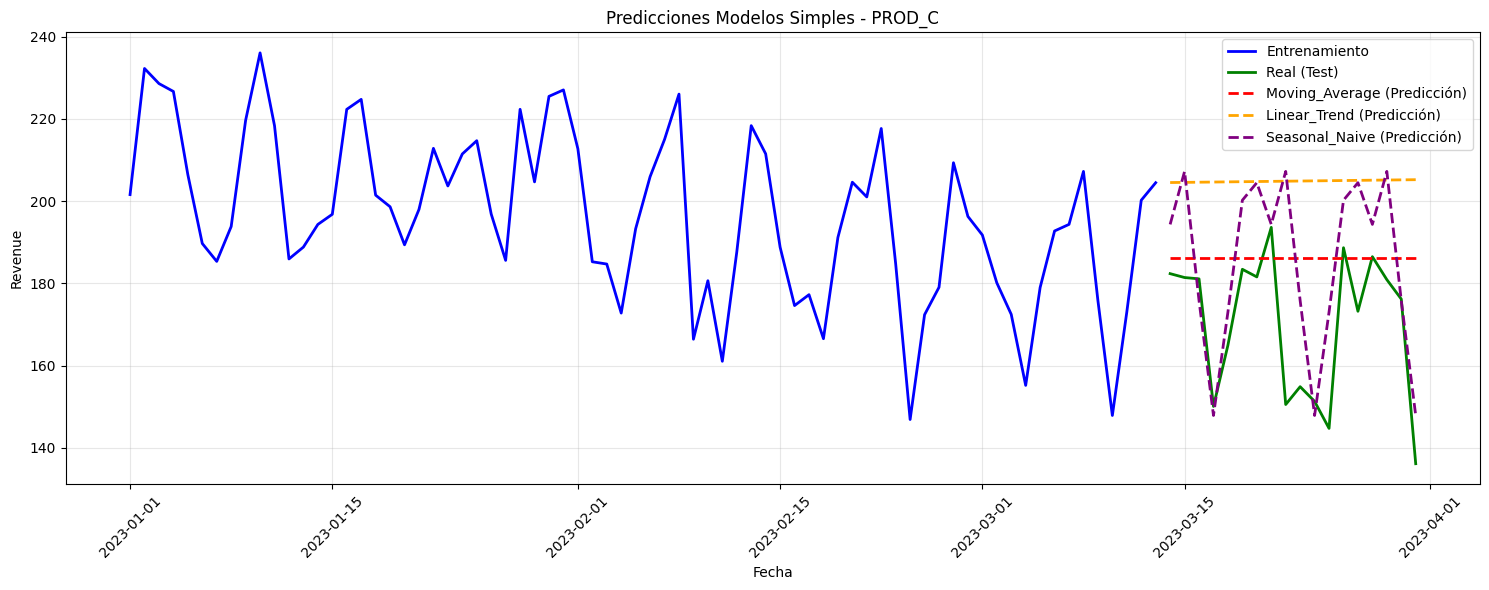

In [10]:
# Visualizar predicciones para cada producto (actualizado)
for product in train_data.keys():
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Datos reales
    train_dates = df_processed[df_processed['product_id'] == product]['date'].iloc[:-len(test_data[product])]
    test_dates = df_processed[df_processed['product_id'] == product]['date'].iloc[-len(test_data[product]):]
    
    ax.plot(train_dates, train_data[product], label='Entrenamiento', color='blue', linewidth=2)
    ax.plot(test_dates, test_data[product], label='Real (Test)', color='green', linewidth=2)
    
    # Predicciones de cada modelo simple
    colors = ['red', 'orange', 'purple']
    for i, (model_name, model_results) in enumerate(simple_results.items()):
        if product in model_results and model_results[product]['success']:
            predictions = model_results[product]['predictions']
            ax.plot(test_dates, predictions, 
                   label=f'{model_name} (Predicción)', 
                   color=colors[i % len(colors)], 
                   linewidth=2, linestyle='--')
    
    ax.set_title(f'Predicciones Modelos Simples - {product}')
    ax.set_xlabel('Fecha')
    ax.set_ylabel('Revenue')
    ax.legend()
    ax.grid(True, alpha=0.3)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

## 7. Análisis de Residuales


Análisis de residuales para PROD_A - Mejor modelo: Seasonal_Naive


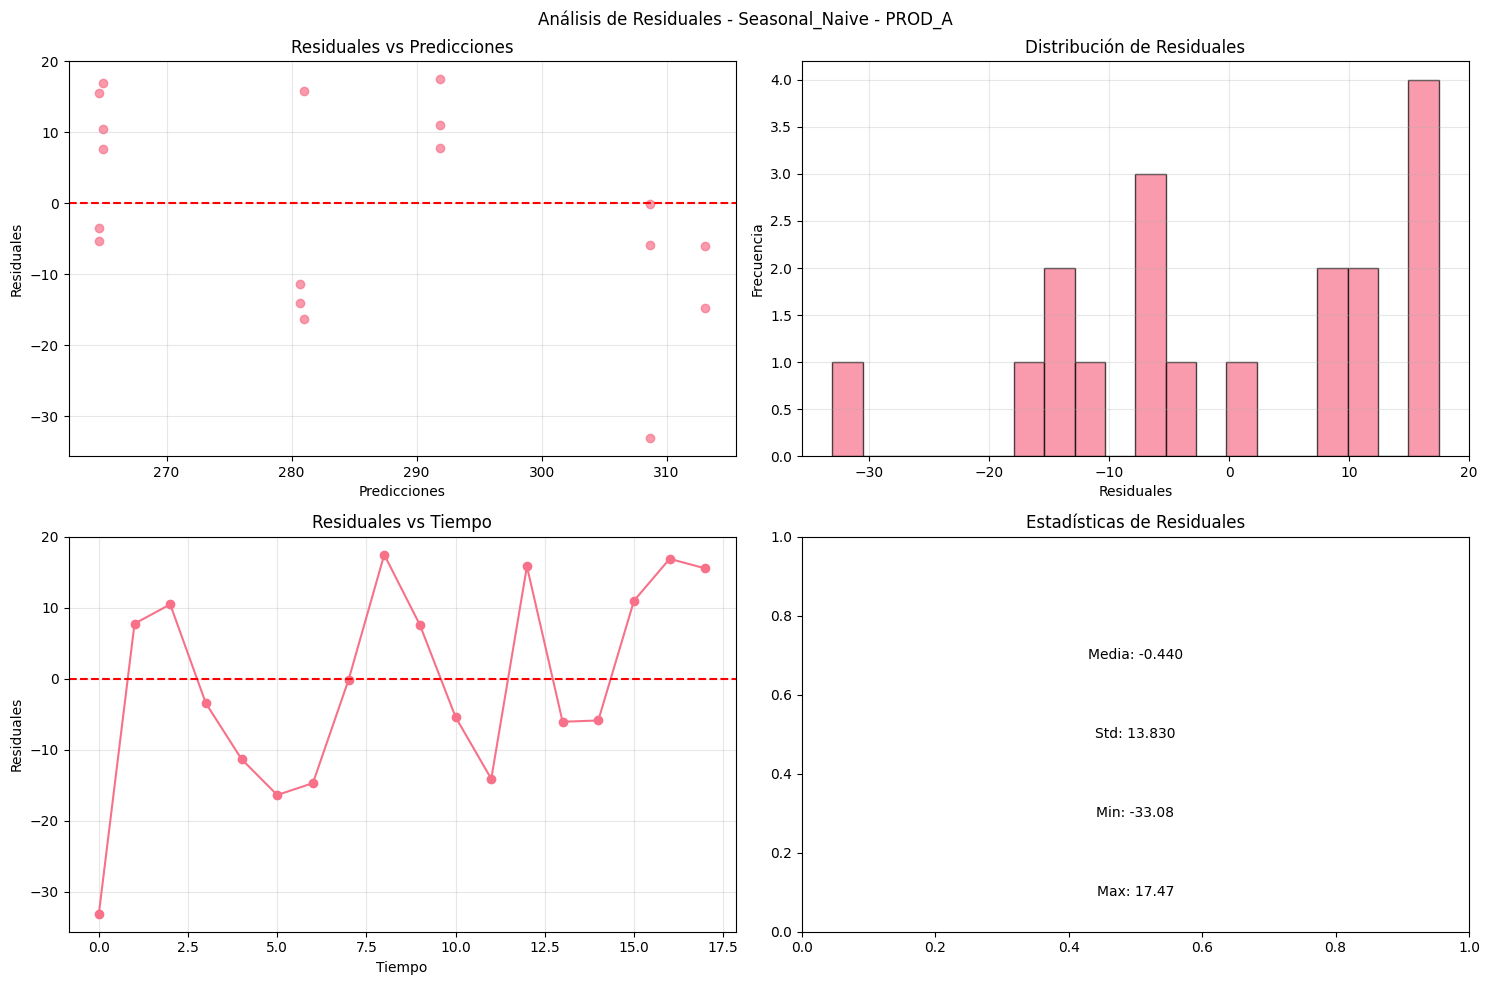


Análisis de residuales para PROD_B - Mejor modelo: Seasonal_Naive


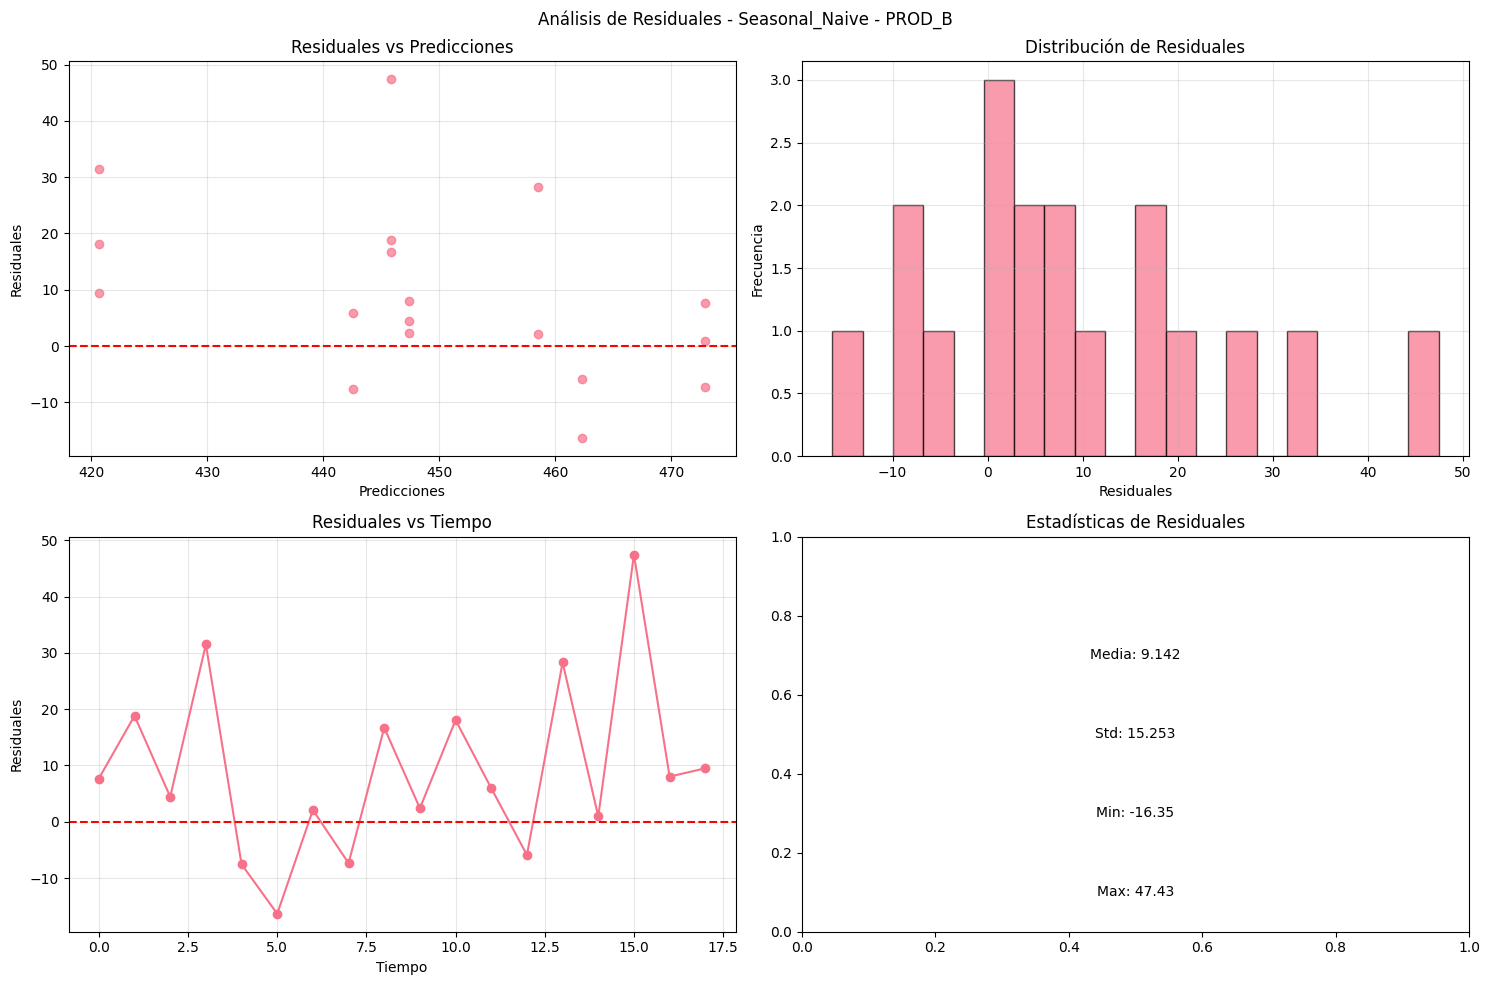


Análisis de residuales para PROD_C - Mejor modelo: Seasonal_Naive


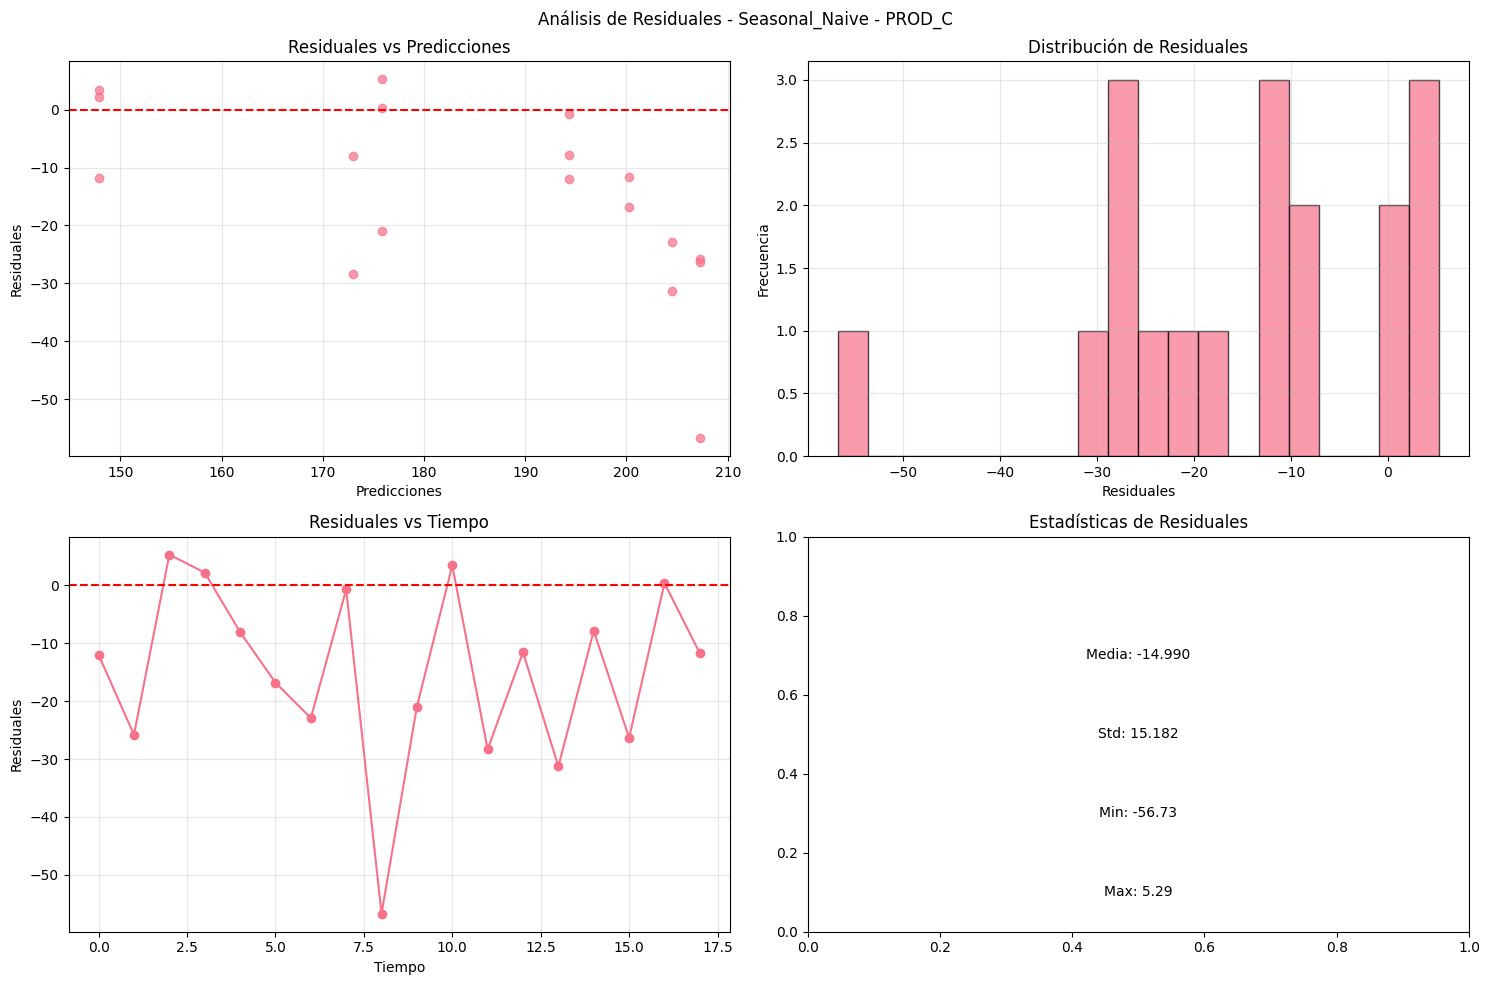

In [11]:
# Análisis de residuales para el mejor modelo (actualizado)
def plot_residual_analysis(y_true, y_pred, model_name, product_id):
    """Crear gráficos de análisis de residuales."""
    residuals = y_true - y_pred
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Residuales vs Predicciones
    axes[0, 0].scatter(y_pred, residuals, alpha=0.7)
    axes[0, 0].axhline(y=0, color='red', linestyle='--')
    axes[0, 0].set_xlabel('Predicciones')
    axes[0, 0].set_ylabel('Residuales')
    axes[0, 0].set_title('Residuales vs Predicciones')
    axes[0, 0].grid(True, alpha=0.3)
    
    # 2. Histograma de residuales
    axes[0, 1].hist(residuals, bins=20, alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Residuales')
    axes[0, 1].set_ylabel('Frecuencia')
    axes[0, 1].set_title('Distribución de Residuales')
    axes[0, 1].grid(True, alpha=0.3)
    
    # 3. Residuales vs Tiempo
    axes[1, 0].plot(range(len(residuals)), residuals, marker='o')
    axes[1, 0].axhline(y=0, color='red', linestyle='--')
    axes[1, 0].set_xlabel('Tiempo')
    axes[1, 0].set_ylabel('Residuales')
    axes[1, 0].set_title('Residuales vs Tiempo')
    axes[1, 0].grid(True, alpha=0.3)
    
    # 4. Estadísticas básicas
    mean_residual = np.mean(residuals)
    std_residual = np.std(residuals)
    axes[1, 1].text(0.5, 0.7, f'Media: {mean_residual:.3f}', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].text(0.5, 0.5, f'Std: {std_residual:.3f}', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].text(0.5, 0.3, f'Min: {np.min(residuals):.2f}', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].text(0.5, 0.1, f'Max: {np.max(residuals):.2f}', 
                   ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title('Estadísticas de Residuales')
    
    plt.suptitle(f'Análisis de Residuales - {model_name} - {product_id}')
    plt.tight_layout()
    plt.show()

# Analizar residuales del mejor modelo para cada producto
for product in train_data.keys():
    best_model = None
    best_rmse = float('inf')
    best_predictions = None
    
    # Encontrar mejor modelo para este producto
    for model_name, model_results in simple_results.items():
        if product in model_results and model_results[product]['success']:
            rmse = model_results[product]['metrics'].get('rmse', float('inf'))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model_name
                best_predictions = model_results[product]['predictions']
    
    if best_model and best_predictions is not None:
        print(f"\nAnálisis de residuales para {product} - Mejor modelo: {best_model}")
        plot_residual_analysis(
            y_true=test_data[product].values,
            y_pred=best_predictions,
            model_name=best_model,
            product_id=product
        )

## 8. Conclusiones y Próximos Pasos

### Resumen de Resultados - Modelos Simples Grupo 2

Basado en los experimentos realizados con modelos simples:

1. **Modelos Evaluados**: 
   - **Moving Average**: Promedio móvil de 7 días
   - **Linear Trend**: Tendencia lineal simple
   - **Seasonal Naive**: Predicción estacional ingenua

2. **Métricas Evaluadas**: MAE, RMSE, MAPE, R²
3. **Enfoque**: Agregación día/producto para Grupo 2

### Próximos Pasos Realistas

1. **Optimización de Parámetros**: 
   - Ajustar ventana del promedio móvil
   - Probar diferentes longitudes estacionales
   
2. **Validación Cruzada**: 
   - Implementar rolling window validation
   - Evaluar estabilidad temporal

3. **Ensambles Simples**: 
   - Combinar mejores modelos individuales
   - Promedio ponderado por performance

4. **Análisis de Errores**:
   - Identificar patrones en residuales
   - Detectar productos problemáticos

### Implementación Práctica

- Pipeline automatizado con modelos simples
- Monitoreo básico de performance
- Alertas por cambios drásticos en predicciones
- Reportes automatizados de precisión

In [12]:
# Guardar resultados para análisis posterior (actualizado para modelos simples)
results_summary = {
    'experiment_date': str(pd.Timestamp.now()),
    'experiment_type': 'Simple Models - Grupo 2',
    'data_shape': df_processed.shape,
    'products_analyzed': list(train_data.keys()),
    'models_tested': list(simple_models.keys()),
    'best_models': {}
}

# Identificar mejor modelo por producto
for product in train_data.keys():
    best_model = None
    best_rmse = float('inf')
    best_metrics = {}
    
    for model_name, model_results in simple_results.items():
        if product in model_results and model_results[product]['success']:
            rmse = model_results[product]['metrics'].get('rmse', float('inf'))
            if rmse < best_rmse:
                best_rmse = rmse
                best_model = model_name
                best_metrics = model_results[product]['metrics']
    
    results_summary['best_models'][product] = {
        'model': best_model,
        'rmse': best_rmse,
        'mae': best_metrics.get('mae', float('inf')),
        'mape': best_metrics.get('mape', float('inf')),
        'r2': best_metrics.get('r2', -1)
    }

print("\n=== RESUMEN FINAL - MODELOS SIMPLES GRUPO 2 ===")
print(f"Fecha del experimento: {results_summary['experiment_date']}")
print(f"Productos analizados: {len(results_summary['products_analyzed'])}")
print(f"Modelos probados: {len(results_summary['models_tested'])}")
print("\nMejores modelos por producto:")
for product, info in results_summary['best_models'].items():
    print(f"  {product}: {info['model']}")
    print(f"    RMSE: {info['rmse']:.2f}")
    print(f"    MAE: {info['mae']:.2f}")
    print(f"    MAPE: {info['mape']:.2f}%")
    print(f"    R²: {info['r2']:.3f}")

# Guardar resultados en archivo JSON
import json
output_path = Path('../results/simple_models_experiment.json')
output_path.parent.mkdir(exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(results_summary, f, indent=2)

print(f"\nResultados guardados en: {output_path}")

# Tabla resumen
print("\n=== TABLA RESUMEN ===")
summary_df = pd.DataFrame(results_summary['best_models']).T
print(summary_df)


=== RESUMEN FINAL - MODELOS SIMPLES GRUPO 2 ===
Fecha del experimento: 2025-10-03 20:09:57.908569
Productos analizados: 3
Modelos probados: 3

Mejores modelos por producto:
  PROD_A: Seasonal_Naive
    RMSE: 13.84
    MAE: 11.83
    MAPE: 4.18%
    R²: 0.362
  PROD_B: Seasonal_Naive
    RMSE: 17.78
    MAE: 13.27
    MAPE: 2.86%
    R²: -0.132
  PROD_C: Seasonal_Naive
    RMSE: 21.34
    MAE: 16.24
    MAPE: 9.84%
    R²: -0.564

Resultados guardados en: ..\results\simple_models_experiment.json

=== TABLA RESUMEN ===
                 model       rmse        mae      mape        r2
PROD_A  Seasonal_Naive  13.836569  11.830362  4.181648  0.362487
PROD_B  Seasonal_Naive  17.783177  13.271371  2.860361 -0.131644
PROD_C  Seasonal_Naive  21.335017  16.244294  9.838528 -0.564301
